In [1]:
!pip install xgboost

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc
from sklearn.svm import SVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.base import clone

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **1.1 Load Data**

In [4]:
!mkdir -p /content/fraud_dataset

In [ ]:
!ls -la /content/fraud_dataset


total 8
drwxr-xr-x 2 root root 4096 Apr 13 21:12 .
drwxr-xr-x 1 root root 4096 Apr 13 21:12 ..


In [5]:
!cp /content/drive/MyDrive/ieee-fraud-detection/train_transaction.csv /content/fraud_dataset/

In [6]:
!cp /content/drive/MyDrive/ieee-fraud-detection/train_identity.csv /content/fraud_dataset/

In [7]:
# Load transaction and identity datasets
transaction_data = pd.read_csv("fraud_dataset/train_transaction.csv")
identity_data = pd.read_csv("fraud_dataset/train_identity.csv")

In [8]:
# Merge datasets on 'TransactionID' (left join to keep all transactions)
data = transaction_data.merge(identity_data, on="TransactionID", how="left")

In [9]:
# Display basic info
print(data.info())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float64(399), int64(4), object(31)
memory usage: 1.9+ GB
None
   TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5  ...                id_31  id_32  \
0    NaN  150.0    discover  142.0  ...                  NaN    NaN   
1  404.0  150.0  mastercard  102.0  ...                  NaN    NaN   
2  490.0  150.0        visa  166.0  ...                  NaN    NaN   
3  567.0  150.0  mastercard  117.0  ...                

In [10]:
# print number of fraudulent and non fraudulent cases
data['isFraud'].value_counts()

,count
isFraud,
0,569877
1,20663


# **1.2 Handle missing values**

In [11]:
# view what format missing data is in
missing_data = data.isnull()
missing_data.head(10)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,False,False,False,False,False,False,True,False,False,False,...,True,True,True,True,True,True,True,True,True,True
1,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
2,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
3,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
6,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
7,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
8,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True


In [12]:
# Calculate missing value percentage
missing_percent = data.isnull().sum() * 100 / len(data)
print(missing_percent)

TransactionID      0.000000
isFraud            0.000000
TransactionDT      0.000000
TransactionAmt     0.000000
ProductCD          0.000000
                    ...    
id_36             76.126088
id_37             76.126088
id_38             76.126088
DeviceType        76.155722
DeviceInfo        79.905510
Length: 434, dtype: float64


In [13]:
threshold = 50

# Drop columns with more than 50% missing values
columns_to_drop = missing_percent[missing_percent > threshold].index
print(columns_to_drop)

data.drop(columns=columns_to_drop, axis=1, inplace=True)

Index(['dist1', 'dist2', 'R_emaildomain', 'D5', 'D6', 'D7', 'D8', 'D9', 'D12',
       'D13',
       ...
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object', length=214)


In [14]:
# Fill missing numerical values with median
for col in data.select_dtypes(include=["float64", "int64"]).columns:
    data.fillna({col: data[col].median()}, inplace=True)


Why Median?

- less sensitive to outliers compared to the mean.
Many transaction-related features (e.g., TransactionAmt) have skewed distributions. The median provides a better central value without being affected by extreme fraud transactions.

In [15]:
# Fill missing categorical values with mode
for col in data.select_dtypes(include=["object"]).columns:
    data.fillna({col: data[col].mode()[0]}, inplace=True)

# **1.3 Data Exploration**

In [16]:
def plot_fraud_vs_non_fraud(data):
    # plot of fraud vs. non-fraud transactions
    sns.countplot(x=data["isFraud"])
    plt.title("Fraud vs Non-Fraud Count")
    plt.xlabel("Fraud (1) vs. Non-Fraud (0)")
    plt.ylabel("Count")
    plt.show()

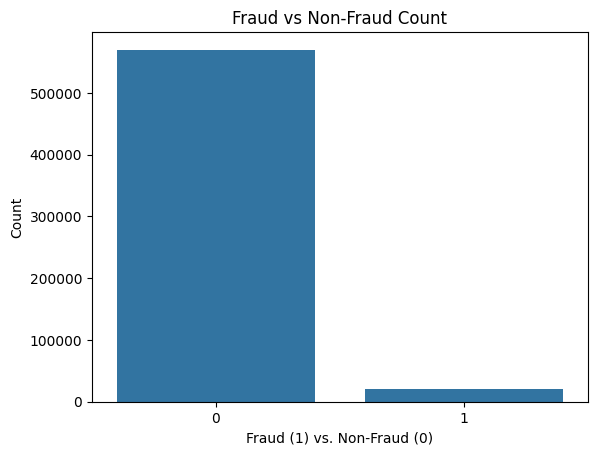

In [17]:
plot_fraud_vs_non_fraud(data)

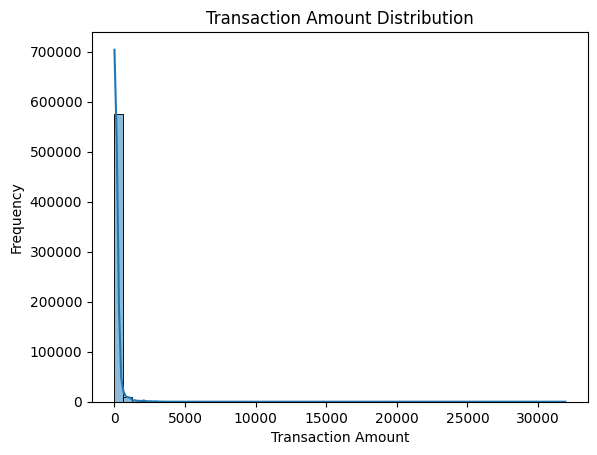

In [18]:
sns.histplot(data["TransactionAmt"], bins=50, kde=True)
plt.title("Transaction Amount Distribution")
plt.xlabel("Transaction Amount")
plt.ylabel("Frequency")
plt.show()


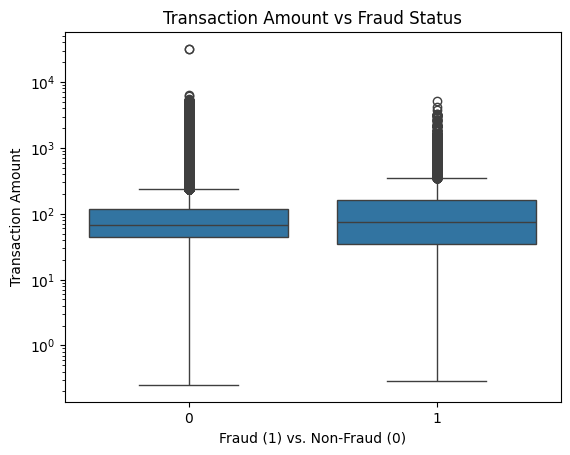

In [19]:
sns.boxplot(x=data["isFraud"], y=data["TransactionAmt"])
plt.title("Transaction Amount vs Fraud Status")
plt.xlabel("Fraud (1) vs. Non-Fraud (0)")
plt.ylabel("Transaction Amount")
plt.yscale("log")  # Log scale for better visibility of outliers
plt.show()


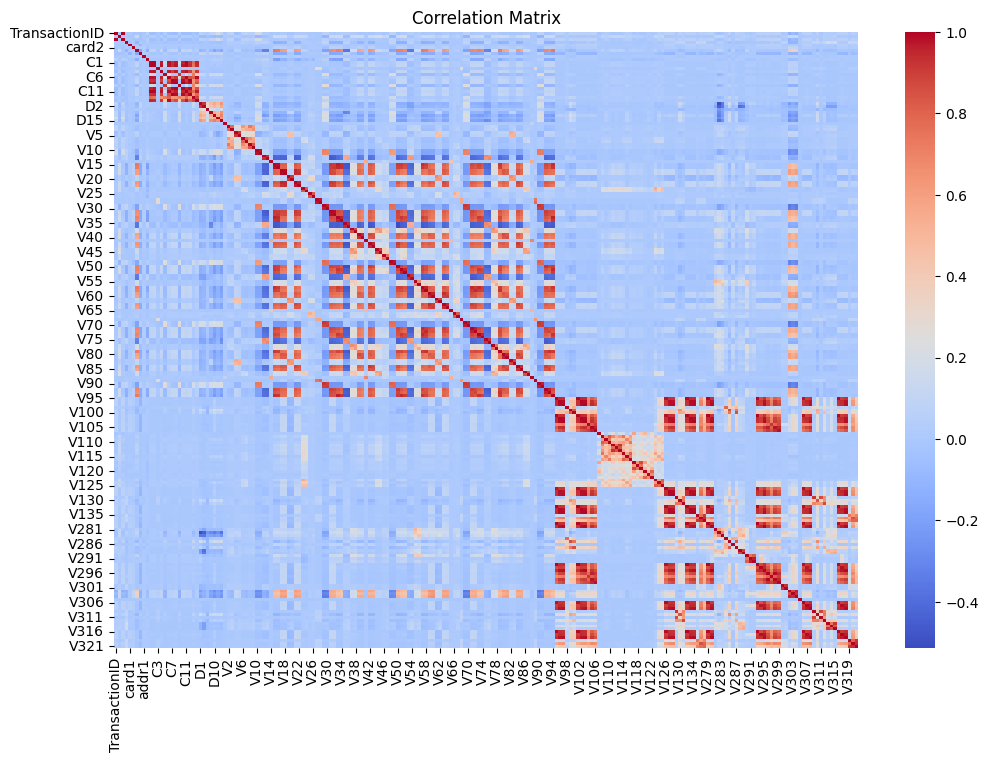

In [20]:
# Select only numeric features for correlation calculation
numeric_data = data.select_dtypes(include=np.number)

# Calculate the correlation matrix
corr_matrix = numeric_data.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False, fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


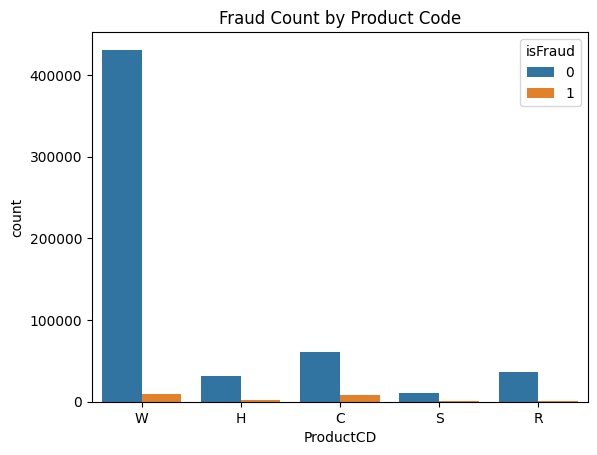

In [21]:
sns.countplot(x="ProductCD", hue="isFraud", data=data)
plt.title("Fraud Count by Product Code")
plt.show()


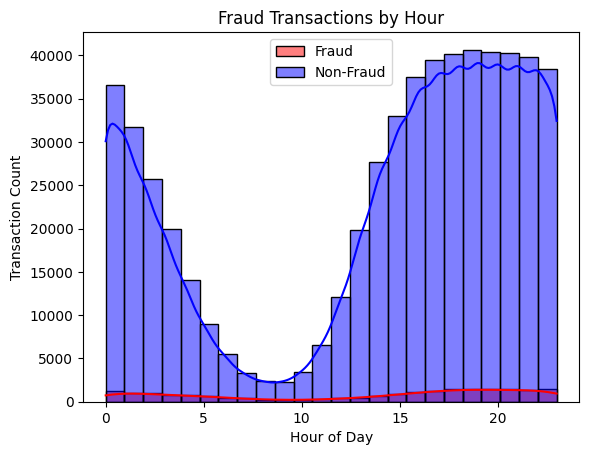

In [22]:
data["TransactionHour"] = (data["TransactionDT"] // 3600) % 24  # Extract hour

sns.histplot(data[data["isFraud"] == 1]["TransactionHour"], bins=24, kde=True, color="red", label="Fraud")
sns.histplot(data[data["isFraud"] == 0]["TransactionHour"], bins=24, kde=True, color="blue", label="Non-Fraud", alpha=0.5)
plt.title("Fraud Transactions by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Transaction Count")
plt.legend()
plt.show()


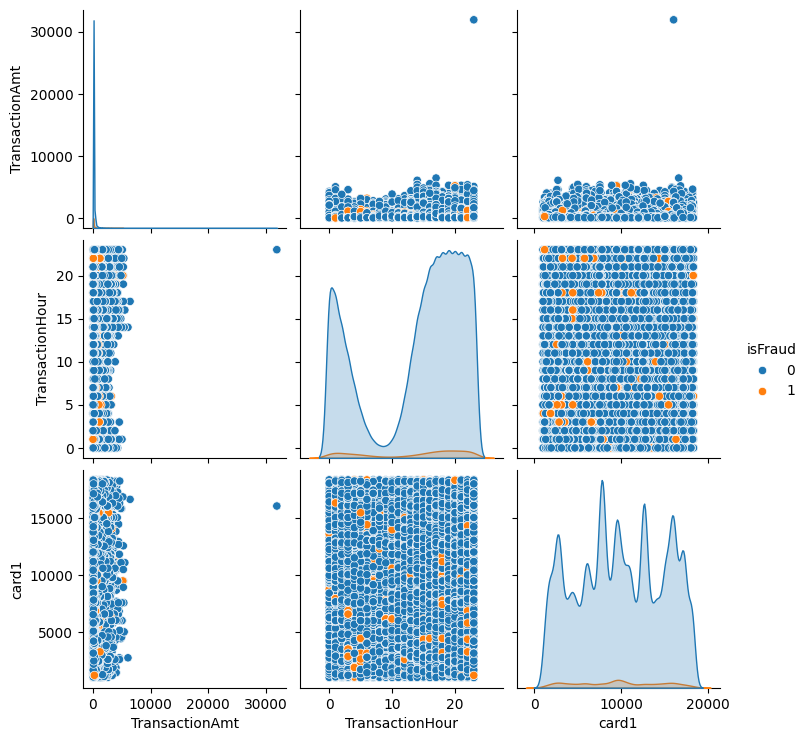

In [ ]:
selected_features = ["TransactionAmt", "TransactionHour", "card1", "isFraud"]
sns.pairplot(data[selected_features], hue="isFraud", diag_kind="kde")
plt.show()
# do not run.

In [23]:
print(len(data.columns))

221


# **1.4 Feature Engineering**

In [24]:
# Convert TransactionDT into hours and days
data["TransactionHour"] = (data["TransactionDT"] // 3600) % 24
data["TransactionDay"] = (data["TransactionDT"] // (3600 * 24)) % 7

# Drop the original TransactionDT column since it's not the actual timestamp
data.drop(columns=["TransactionDT"], inplace=True)


In [25]:
# Mean Transaction Amount per Card
data["Mean_TransactionAmt_per_Card"] = data.groupby("card1")["TransactionAmt"].transform("mean")

# Standard Deviation of Transaction Amount per Card
data["Std_TransactionAmt_per_Card"] = data.groupby("card1")["TransactionAmt"].transform("std")

# Number of Transactions per Card
data["Transaction_Frequency_per_Card"] = data.groupby("card1")["TransactionID"].transform("count")

# Fill NaN values in aggregated columns
data.fillna(0, inplace=True)



In [26]:
# Separate features and target
X = data.drop("isFraud", axis=1)
y = data["isFraud"]

# Train-test split (stratify to preserve class distribution in test set)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [27]:
# Balance only the training data
train_data = pd.concat([X_train, y_train], axis=1)
fraud_data = train_data[train_data['isFraud'] == 1]
non_fraud_data = train_data[train_data['isFraud'] == 0]

print(len(fraud_data))
print(len(non_fraud_data))

16530
455902


In [28]:
# Undersample non-fraud class
non_fraud_undersampled_data = non_fraud_data.sample(n=len(fraud_data), random_state=42)
balanced_train_data = pd.concat([fraud_data, non_fraud_undersampled_data]).sample(frac=1, random_state=42)

print(len(balanced_train_data))

33060


In [29]:
# Final balanced X and y
X_train_bal = balanced_train_data.drop("isFraud", axis=1)
y_train_bal = balanced_train_data["isFraud"]

print(len(X_train_bal))
print(len(y_train_bal))

33060
33060


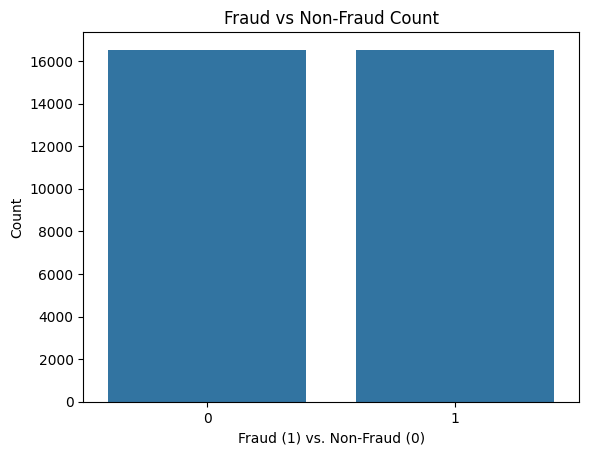

In [30]:
plot_fraud_vs_non_fraud(balanced_train_data)

In [31]:
# Display basic info
print(balanced_train_data.info())
print(balanced_train_data.head())

<class 'pandas.core.frame.DataFrame'>
Index: 33060 entries, 486955 to 573607
Columns: 224 entries, TransactionID to isFraud
dtypes: float64(209), int64(6), object(9)
memory usage: 56.8+ MB
None
        TransactionID  TransactionAmt ProductCD  card1  card2  card3  \
486955        3473955           47.95         W  16727  111.0  150.0   
402578        3389578          167.00         W   5033  269.0  150.0   
371786        3358786          150.00         R  13305  399.0  150.0   
182655        3169655          200.00         R   4141  404.0  150.0   
329844        3316844          496.00         W  17739  512.0  150.0   

                   card4  card5   card6  addr1  ...  V318 V319  V320  V321  \
486955              visa  226.0  credit  204.0  ...   0.0  0.0   0.0   0.0   
402578        mastercard  224.0   debit  264.0  ...  54.0  0.0   0.0   0.0   
371786  american express  133.0  credit  469.0  ...   0.0  0.0   0.0   0.0   
182655        mastercard  102.0  credit  191.0  ...   0.0  0.

In [32]:
# Identify non-numeric columns
non_numeric_cols = X_train_bal.select_dtypes(include='object').columns
print(non_numeric_cols)


Index(['ProductCD', 'card4', 'card6', 'P_emaildomain', 'M1', 'M2', 'M3', 'M4',
       'M6'],
      dtype='object')


In [33]:
for col in non_numeric_cols:
    le = LabelEncoder()
    # Combine train and test to keep label consistency
    combined = pd.concat([X_train_bal[col], X_test[col]], axis=0).astype(str)
    le.fit(combined)
    X_train_bal[col] = le.transform(X_train_bal[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))


Random Forest Feature Importances

It works well for tabular data and handles both numerical and categorical features.

In [34]:
# Train model on balanced training data
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1) #n_jobs=1 uses all CPU for faster training
rf.fit(X_train_bal, y_train_bal)

# Get feature importances
importances = pd.Series(rf.feature_importances_, index=X_train_bal.columns)
top_features = importances.sort_values(ascending=False).head(50).index

# Reduce training and test data to top features
X_train_selected = X_train_bal[top_features]
X_test_selected = X_test[top_features]


In [35]:
print(X_train_selected)

         C13  TransactionAmt  TransactionID  Mean_TransactionAmt_per_Card  \
486955   1.0           47.95        3473955                    234.644672   
402578   4.0          167.00        3389578                    107.136529   
371786   1.0          150.00        3358786                    227.272727   
182655   0.0          200.00        3169655                    236.619574   
329844  20.0          496.00        3316844                    324.625000   
...      ...             ...            ...                           ...   
215289  13.0           47.95        3202289                    118.491604   
55728    0.0           75.00        3042728                    204.825116   
451533   2.0          554.00        3438533                    307.785798   
240827   0.0          100.00        3227827                    184.615385   
573607   0.0          150.00        3560607                    206.321333   

        Std_TransactionAmt_per_Card  C14  Transaction_Frequency_per_Card  \

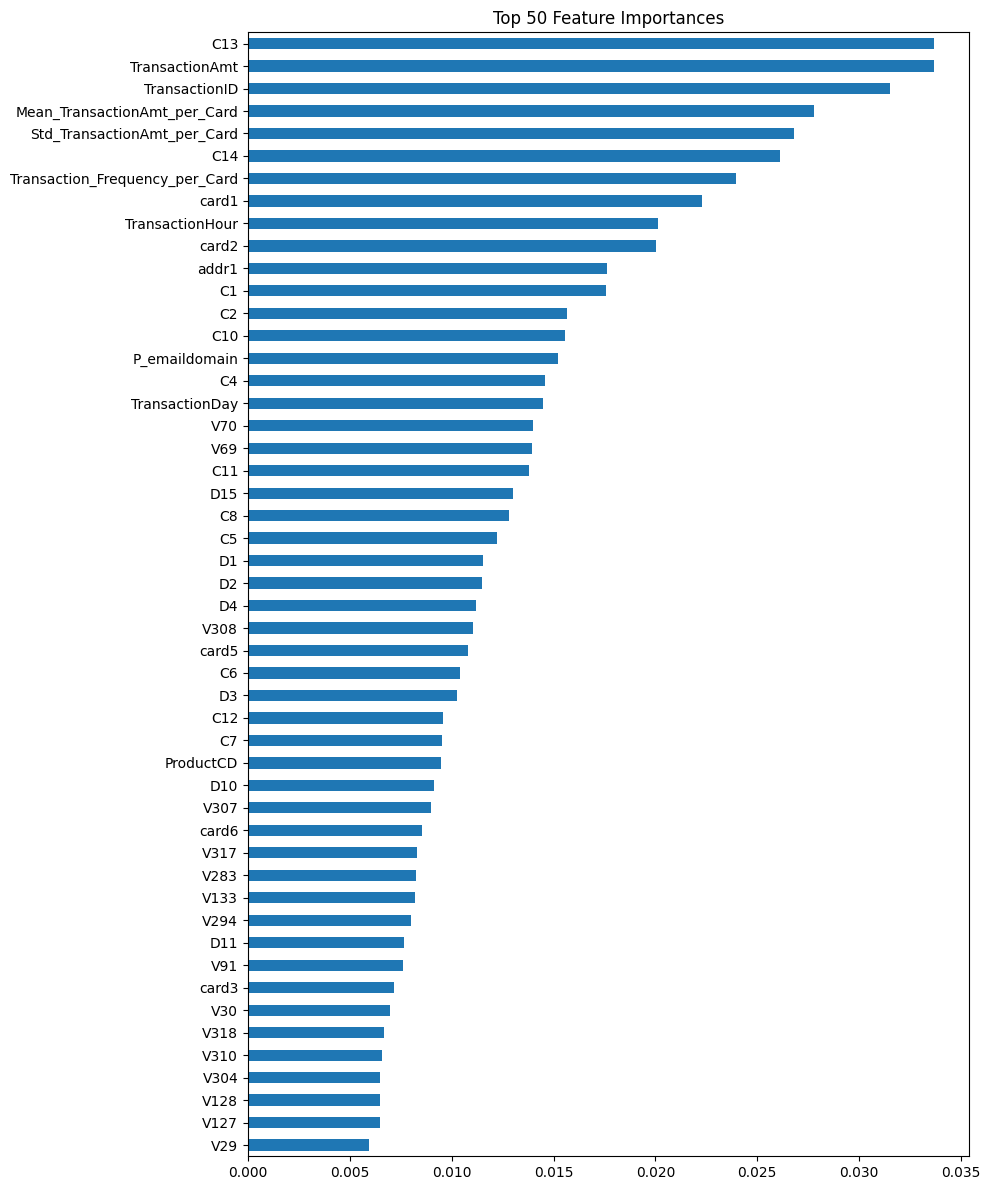

In [36]:
importances[top_features].sort_values().plot(kind='barh', figsize=(10, 12))
plt.title("Top 50 Feature Importances")
plt.tight_layout()
plt.show()


# Model Training

Logistic Regression

In [37]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

In [38]:
# split X_train_scaled to training and validation data
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train_scaled, y_train_bal, test_size=0.2, random_state=42, stratify=y_train_bal
)

In [39]:
# Train Logistic Regression on split data
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_split, y_train_split)

LogisticRegression(max_iter=1000, random_state=42)

In [40]:
# Predict on validation data
y_val_proba = lr.predict_proba(X_val)[:, 1]

In [41]:
def print_validation_roc_auc(y_val, y_val_proba):
    val_auc = roc_auc_score(y_val, y_val_proba)
    print(f"Validation ROC AUC: {val_auc:.4f}")

In [42]:
print_validation_roc_auc(y_val, y_val_proba)

Validation ROC AUC: 0.8023


In [43]:
def plot_learning_curve_roc_auc(model, X_train, y_train, X_val, y_val, train_sizes=np.linspace(0.1, 1.0, 10)):
    train_scores = []
    val_scores = []

    for frac in train_sizes:
        n_samples = int(frac * X_train.shape[0])
        X_sub = X_train[:n_samples]
        y_sub = y_train[:n_samples]

        model_clone = clone(model)
        model_clone.fit(X_sub, y_sub)

        y_sub_proba = model_clone.predict_proba(X_sub)[:, 1]
        y_val_proba = model_clone.predict_proba(X_val)[:, 1]

        train_auc = roc_auc_score(y_sub, y_sub_proba)
        val_auc = roc_auc_score(y_val, y_val_proba)

        train_scores.append(train_auc)
        val_scores.append(val_auc)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes * 100, train_scores, label='Training ROC AUC')
    plt.plot(train_sizes * 100, val_scores, label='Validation ROC AUC')
    plt.xlabel('Training Set Size (%)')
    plt.ylabel('ROC AUC')
    plt.title(f'Learning Curve - {type(model).__name__}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


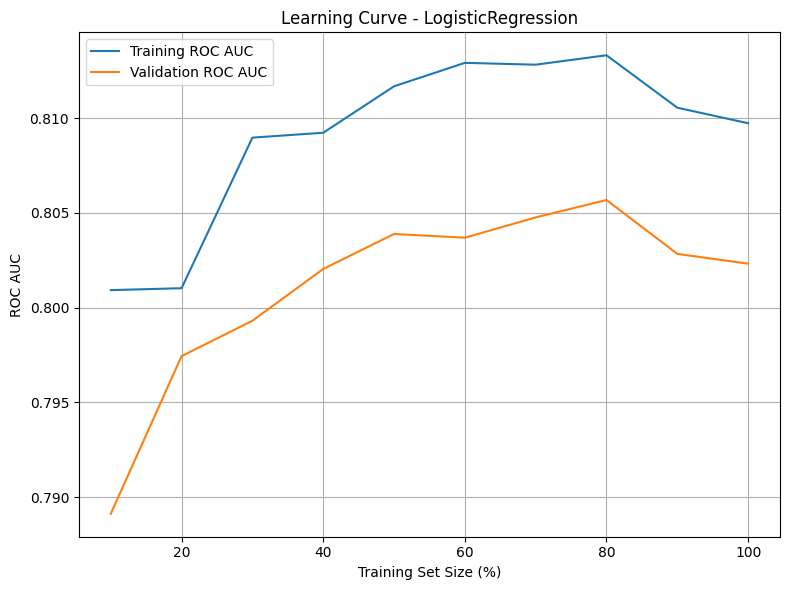

In [44]:
plot_learning_curve_roc_auc(lr, X_train_split, y_train_split, X_val, y_val)

In [45]:
def grid_search(model, param_grid, X_train, y_train):
    grid = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
    grid.fit(X_train, y_train)

    print("Best Params:", grid.best_params_)
    print("Best ROC AUC:", grid.best_score_)
    return grid

In [46]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100]
}

grid = grid_search(lr, param_grid, X_train_split, y_train_split)

Best Params: {'C': 100}
Best ROC AUC: 0.8111625254714963


In [47]:
tuned_lr = grid.best_estimator_

In [48]:
tuned_lr.fit(X_train_split, y_train_split)

LogisticRegression(C=100, max_iter=1000, random_state=42)

In [49]:
tuned_y_val_proba = tuned_lr.predict_proba(X_val)[:, 1]
print_validation_roc_auc(y_val, tuned_y_val_proba)

Validation ROC AUC: 0.8047


In [50]:
# initialize model with updated parameters
final_lr = LogisticRegression(C=100, max_iter=1000, random_state=42)
final_lr.fit(X_train_scaled, y_train_bal)

LogisticRegression(C=100, max_iter=1000, random_state=42)

In [51]:
# Predict on test data
y_pred = final_lr.predict(X_test_scaled)
y_proba = final_lr.predict_proba(X_test_scaled)[:, 1]

Evaluation

In [52]:
def print_model_evaluation(y_test, y_pred, y_proba):
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    print("\nROC-AUC Score:")
    print(roc_auc_score(y_test, y_proba))


In [53]:
print_model_evaluation(y_test, y_pred, y_proba)

Confusion Matrix:
[[83770 30205]
 [ 1076  3057]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.73      0.84    113975
           1       0.09      0.74      0.16      4133

    accuracy                           0.74    118108
   macro avg       0.54      0.74      0.50    118108
weighted avg       0.96      0.74      0.82    118108


ROC-AUC Score:
0.8100661621399924


In [54]:
def plot_roc_curve(y_test, y_proba, model_name):
    # Compute ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    # Plot
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f'ROC Curve - {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

In [55]:
def plot_precision_recall_curve(y_test, y_proba, model_name):
    # Compute Precision-Recall
    precision, recall, _ = precision_recall_curve(y_test, y_proba)

    # Plot
    plt.figure(figsize=(8,6))
    plt.plot(recall, precision, label="Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

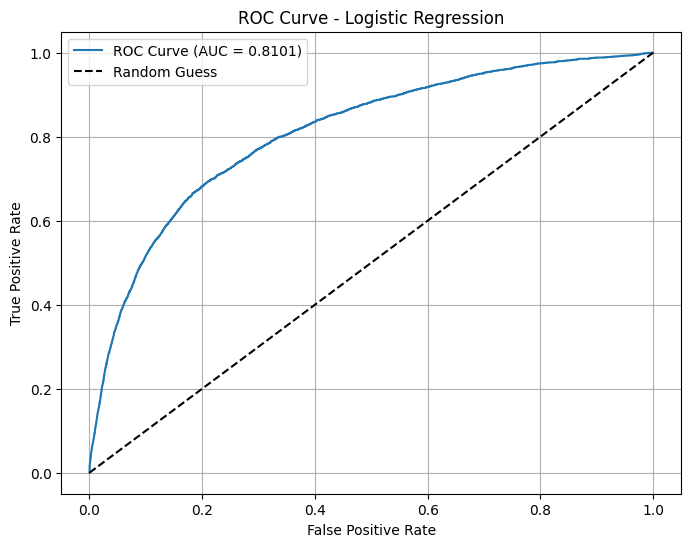

In [56]:
plot_roc_curve(y_test, y_proba, "Logistic Regression")

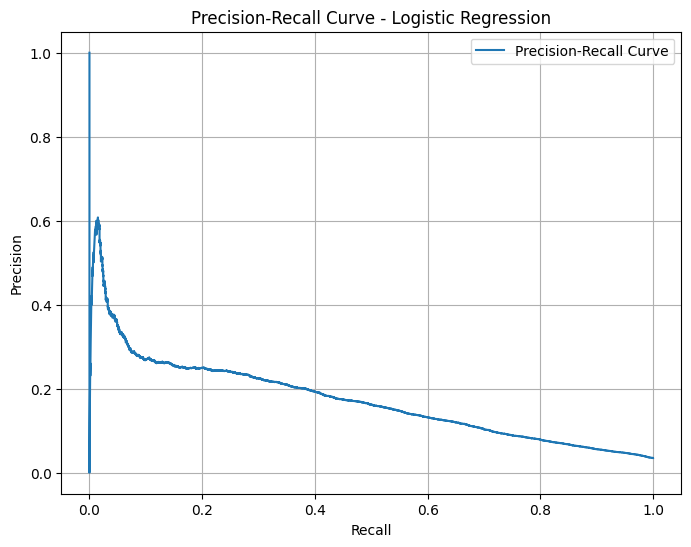

In [57]:
plot_precision_recall_curve(y_test, y_proba, "Logistic Regression")

# SVM

In [58]:
# SVM with probability=True to get ROC/PR curves
svm = SVC(kernel='rbf', C=1.0, probability=True, random_state=42)

In [59]:
svm.fit(X_train_split, y_train_split)

SVC(probability=True, random_state=42)

In [60]:
# Predict on validation data
y_val_proba = svm.predict_proba(X_val)[:, 1]

print_validation_roc_auc(y_val, y_val_proba)

Validation ROC AUC: 0.8431


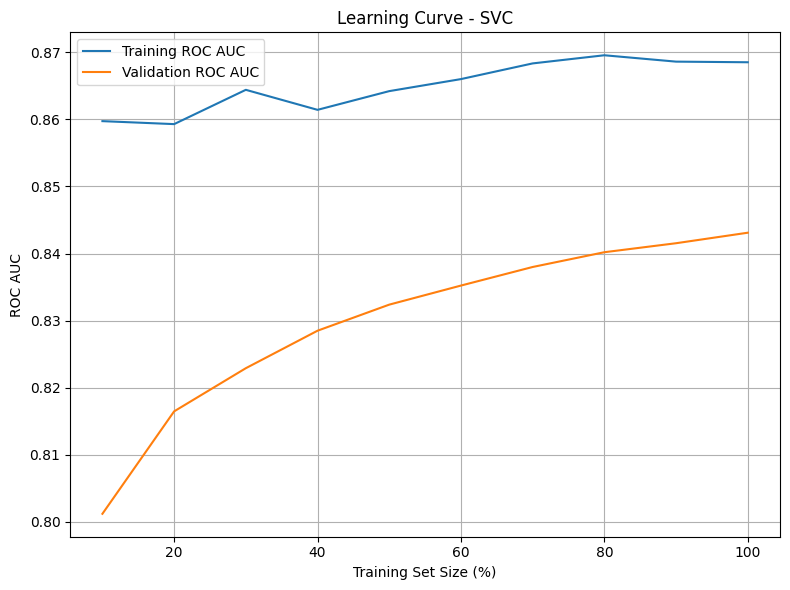

In [61]:
plot_learning_curve_roc_auc(svm, X_train_split, y_train_split, X_val, y_val)

In [62]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.01, 0.1, 1]
}

grid = grid_search(svm, param_grid, X_train_split, y_train_split)

# do not run because it takes too long

KeyboardInterrupt: 

In [63]:
# initialize model with updated parameters
final_svm = SVC(C=100, gamma=0.1, kernel='rbf', probability=True, random_state=42)
final_svm.fit(X_train_scaled, y_train_bal)

SVC(C=100, gamma=0.1, probability=True, random_state=42)

In [64]:
# Predict
y_pred = final_svm.predict(X_test_scaled)
y_proba = final_svm.predict_proba(X_test_scaled)[:, 1]

In [65]:
print_model_evaluation(y_test, y_pred, y_proba)

Confusion Matrix:
[[92098 21877]
 [  667  3466]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.81      0.89    113975
           1       0.14      0.84      0.24      4133

    accuracy                           0.81    118108
   macro avg       0.56      0.82      0.56    118108
weighted avg       0.96      0.81      0.87    118108


ROC-AUC Score:
0.8836506895876612


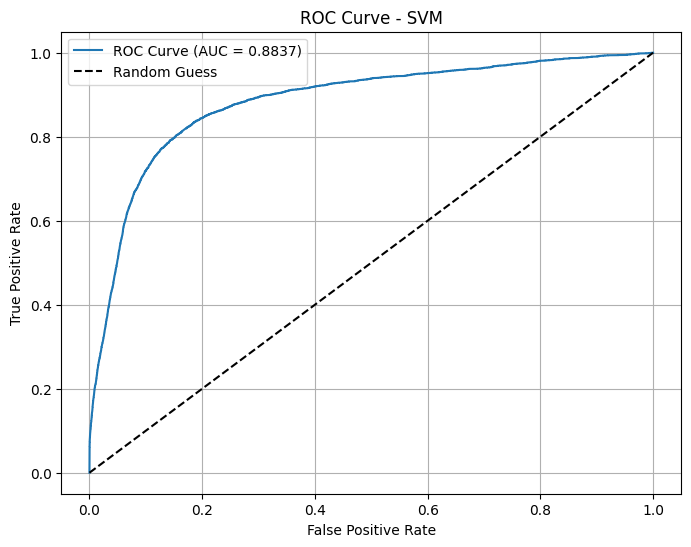

In [66]:
plot_roc_curve(y_test, y_proba, "SVM")

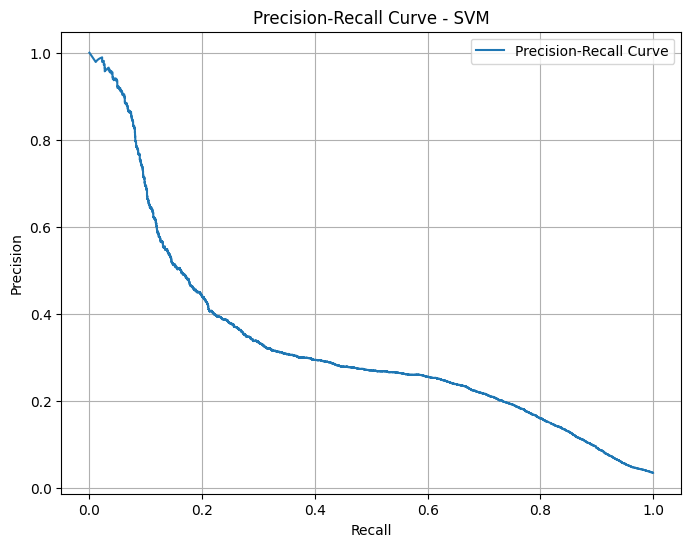

In [67]:
plot_precision_recall_curve(y_test, y_proba, "SVM")

Evaluation

In [ ]:
# former roc score

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nROC-AUC Score:")
print(roc_auc_score(y_test, y_proba))


Confusion Matrix:
[[90297 23678]
 [  978  3155]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.79      0.88    113975
           1       0.12      0.76      0.20      4133

    accuracy                           0.79    118108
   macro avg       0.55      0.78      0.54    118108
weighted avg       0.96      0.79      0.86    118108


ROC-AUC Score:
0.8541479604425074


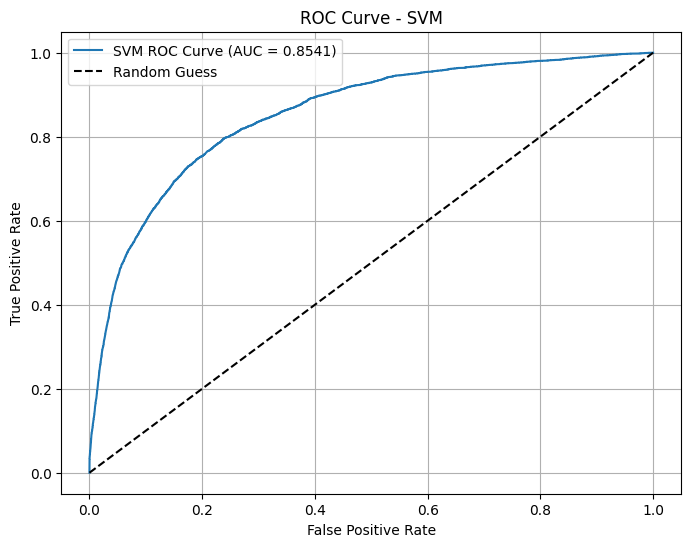

In [ ]:
# ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"SVM ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - SVM")
plt.legend()
plt.grid(True)
plt.show()

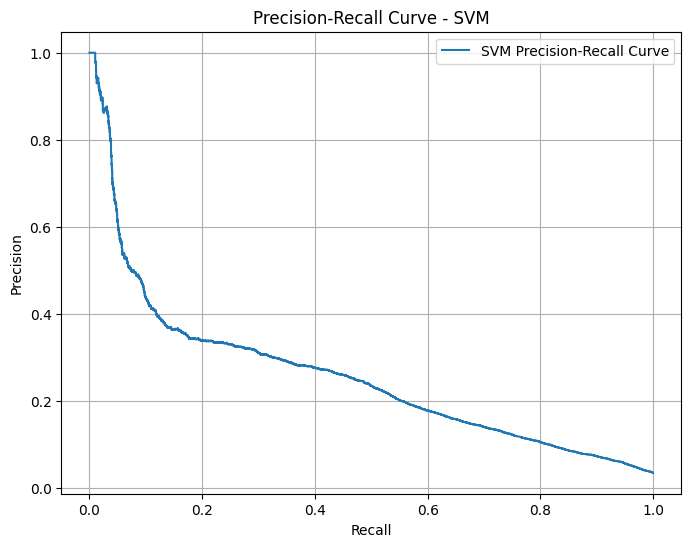

In [ ]:
# Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label="SVM Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - SVM")
plt.legend()
plt.grid(True)
plt.show()


# XGBoost

In [ ]:
# Initialize model
xgb_clf = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

In [ ]:
# split X_train_selected to training and validation data
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train_selected, y_train_bal, test_size=0.2, random_state=42, stratify=y_train_bal
)

In [ ]:
xgb_clf.fit(X_train_selected, y_train_bal)

In [ ]:
# Predict
y_pred = xgb_clf.predict(X_test_selected)
y_proba = xgb_clf.predict_proba(X_test_selected)[:, 1]

Evaluation

In [ ]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nROC-AUC Score:")
print(roc_auc_score(y_test, y_proba))


Confusion Matrix:
[[100368  13607]
 [   733   3400]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.88      0.93    113975
           1       0.20      0.82      0.32      4133

    accuracy                           0.88    118108
   macro avg       0.60      0.85      0.63    118108
weighted avg       0.97      0.88      0.91    118108


ROC-AUC Score:
0.9301313918059145


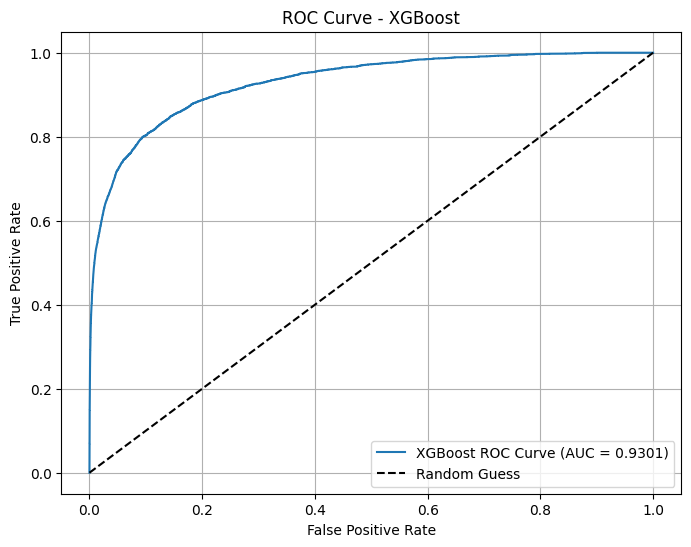

In [ ]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"XGBoost ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost")
plt.legend()
plt.grid(True)
plt.show()

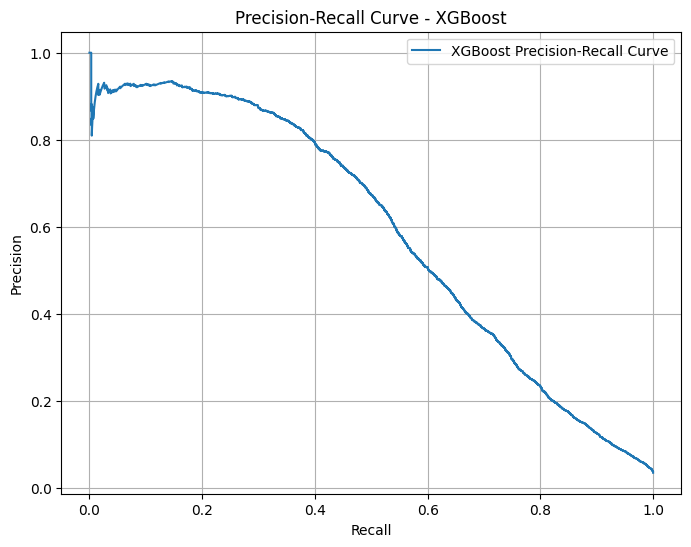

In [ ]:
# Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label="XGBoost Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - XGBoost")
plt.legend()
plt.grid(True)
plt.show()

# Deep Learning

# CNN

In [ ]:
1# Reshape to: (samples, height, width, channels)
X_train_cnn = X_train_scaled.reshape(-1, 5, 10, 1)
X_test_cnn = X_test_scaled.reshape(-1, 5, 10, 1)


In [ ]:
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(5, 10, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # binary classification
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_train_cnn, y_train_bal,
                    epochs=10, batch_size=64,
                    validation_split=0.2, verbose=1)

Epoch 1/10
414/414 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.7817 - loss: 0.4693 - val_accuracy: 0.7786 - val_loss: 0.4813
Epoch 2/10
414/414 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.7816 - loss: 0.4647 - val_accuracy: 0.7747 - val_loss: 0.4740
Epoch 3/10
414/414 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7801 - loss: 0.4653 - val_accuracy: 0.7772 - val_loss: 0.4749
Epoch 4/10
414/414 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7816 - loss: 0.4695 - val_accuracy: 0.7748 - val_loss: 0.4753
Epoch 5/10
414/414 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7861 - loss: 0.4572 - val_accuracy: 0.7795 - val_loss: 0.4731
Epoch 6/10
414/414 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7843 - loss: 0.4624 - val_accuracy: 0.7768 - val_loss: 0.4708
Epoch 7/10
414/414 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7829 - loss: 0.4663 - val_accuracy: 0.7777 - val_loss: 0.4709
Epoch 8/10
414/414 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7850 - loss: 0.4579 - val_accuracy: 

In [ ]:
# Predict probabilities
y_proba = model.predict(X_test_cnn).flatten()
y_pred = (y_proba > 0.5).astype(int)


3691/3691 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step


In [ ]:
# Evaluation
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nROC-AUC Score:")
print(roc_auc_score(y_test, y_proba))

Confusion Matrix:
[[87098 26877]
 [  825  3308]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.76      0.86    113975
           1       0.11      0.80      0.19      4133

    accuracy                           0.77    118108
   macro avg       0.55      0.78      0.53    118108
weighted avg       0.96      0.77      0.84    118108


ROC-AUC Score:
0.8610004571086606


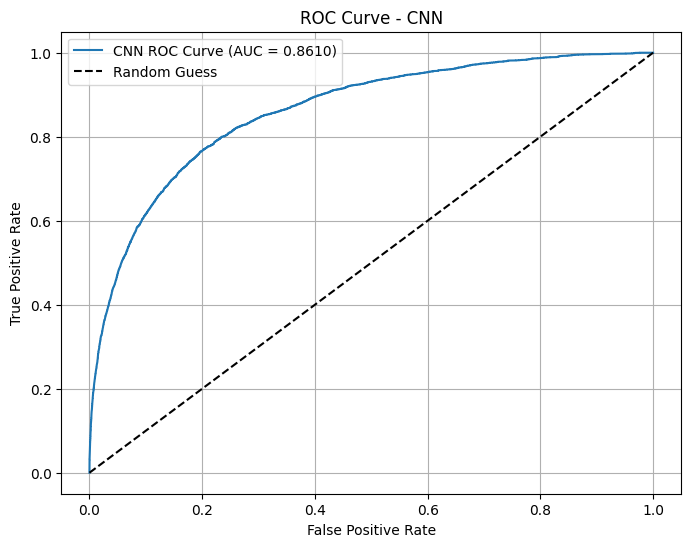

In [ ]:
# ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"CNN ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - CNN")
plt.legend()
plt.grid(True)
plt.show()


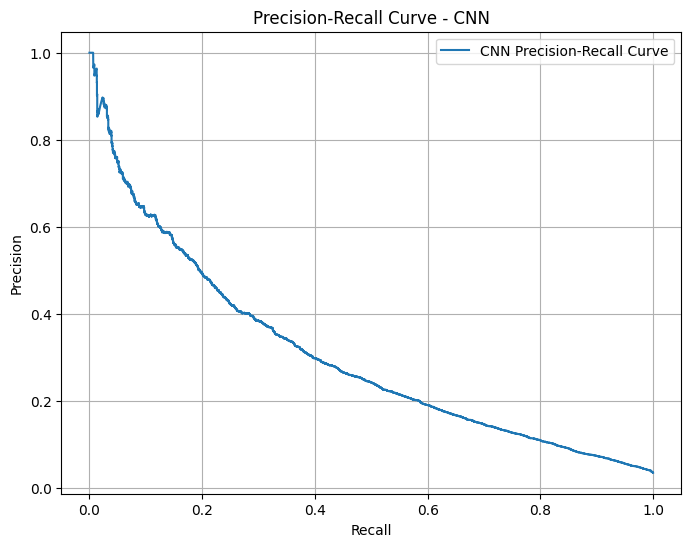

In [ ]:

# PR
precision, recall, _ = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label="CNN Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - CNN")
plt.legend()
plt.grid(True)
plt.show()

## Learning curve
